In [321]:
import numpy as np
import matplotlib.pyplot as plt

In [322]:

# сеточный оператор Лапласа
def laplas(u_points, h):
    return (np.roll(u_points, 1, 0) - 2 * u_points + np.roll(u_points, -1, 0) + np.roll(u_points, 1, 1) - 2 * u_points + np.roll(u_points, -1, 1)) / h ** 2

# постановка гран условий
def edge_conditions(sol, u, points):
    u_gran = u(points)
    u_gran[1:-1, 1:-1] = 0
    sol[:, 0] = sol[0, :] = sol[:, -1] = sol[-1, :] = 0
    sol = sol + u_gran
    return sol

# метод простой итерации
def simple_iteration(u_points, f, u, h, tau, X, Y):
    points = np.broadcast_arrays(np.linspace(0, X, int(X / h) + 1).reshape((-1, 1)), np.linspace(0, Y, int(Y / h) + 1))
    f_points = f(points)
    new_u_points = u_points + tau * (laplas(u_points, h) - f_points)
    return edge_conditions(new_u_points, u, points)

# норма разности друх матриц
def norm(a, b):
    return np.max(np.abs(a - b))

# погрешность на последнем шаге
def epsilon(u):
    if len(u) < 2:
        return np.Inf
    else:
        return norm(u[-1], u[-2])

# главный цикл
def method(step, f, u, h, tau, X, Y, e=1e-4):
    sol_0 = np.ones((int(X / h) + 1, int(Y / h) + 1))
    sol = [sol_0]
    n = 0
    while epsilon(sol) > e:
        sol.append(step(sol[-1], f, u, h, tau, X, Y))
    return sol[-1]

# рисование графика
def draw_3D_plot(h, X, Y, u):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(np.array([i * h for i in range(int(X / h) + 1)]), np.array([i * h for i in range(int(Y / h) + 1)]), u, 100, )
    ax.view_init(30, 135)


In [323]:
# функция f из условия
def f(point):
    x, y = point
    return -32 * (x * (1 - x) + y * (1 - y))

# граничное условие
def u(point):
    x, y = point
    return np.zeros_like(x)

# класс для Попеременно-треугольного итерационного метода (ПТИМ)
class PTIM:
    def __init__(self, h, tau, X, Y) -> None:
        self.h = h
        self.tau = tau
        self.X = X
        self.Y = Y

    # матрица оператора Лапласа    
    def laplace_matrix(self):
        n = int(self.X / self.h) + 1
        self.A = np.zeros((n ** 2, n ** 2))
        for i in range(n):
            for j in range(n):
                u = np.zeros((n, n))
                u[i][j] = 1
                res = laplas(u, self.h)
                self.A[:, i * n + j] = res.flatten()
        E = np.eye(self.A.shape[0], self.A.shape[1])
        return self.A

    # R - матрицы из метода
    def R_matrices(self):
        self.R1 = np.tril(self.A) - np.eye(self.A.shape[0], self.A.shape[1]) / 2 * self.A
        self.R2 = np.transpose(self.R1)
        return self.R1, self.R2

    # матрицы (E - tau * R1,2)
    def inv_matrices(self):
        E = np.eye(self.R1.shape[0], self.R1.shape[1])
        return np.linalg.inv(E - self.tau * self.R1), np.linalg.inv(E - self.tau * self.R2)

    # матрица B
    def B_matrix(self):
        E = np.eye(self.R1.shape[0], self.R1.shape[1])
        return (E - self.tau * self.R1) @ (E - self.tau * self.R2)

    # инициализация всех матриц
    def init_matrices(self):
        self.A = self.laplace_matrix()
        self.R1, self.R2 = self.R_matrices()
        self.invR1, self.invR2 = self.inv_matrices()
        self.B = self.B_matrix()
        return self.A, self.R1, self.R2, self.invR1, self.invR2, self.B
    
    # шаг метода
    def triangle(self, u_points, f, u, h, tau, X, Y):
        points = np.broadcast_arrays(np.linspace(0, self.X, int(self.X / self.h) + 1).reshape((-1, 1)), np.linspace(0, self.Y, int(self.Y / self.h) + 1))
        shape = u_points.shape
        f_points = f(points)
        u_points = u_points.reshape(1, -1)[0]
        f_points = f_points.flatten()
        r = self.A @ u_points - f_points
        u_wave = self.invR2 @ (self.B @ u_points + self.tau * r)
        new_u_points = self.invR1 @ u_wave
        new_u_points = new_u_points.reshape(shape)
        return edge_conditions(new_u_points, u, points)
        

In [324]:
h = 1/15
M = 1 / h
l = 2 * np.pi ** 2
L = 8 * M ** 2
tau = 2 / (l + L)
X = 1
Y = 1
gamma1 = l / 2 / (1 + (l / L) ** 0.5)
gamma2 = (l * L) ** 0.5 / 4
tau2 = 2 / (gamma1 + gamma2)
# A, R1, R2, invR1, invR2, B = init_matrices(h, tau, X, Y)

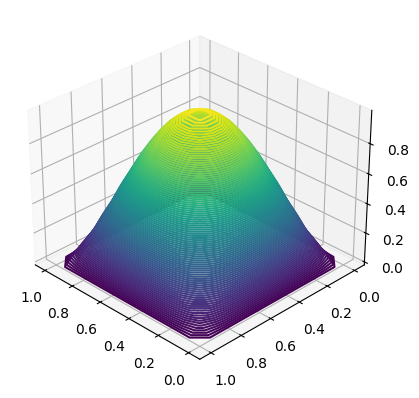

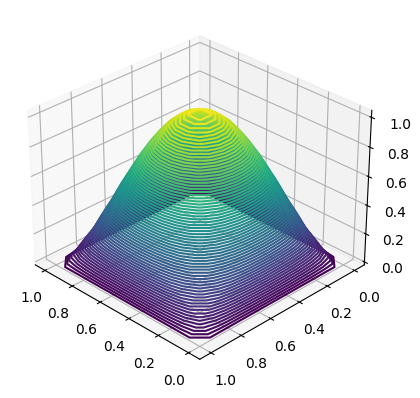

In [325]:

ptim = PTIM(h, tau2 / 100, X, Y)
ptim.init_matrices()
solution1 = method(simple_iteration, f, u, h, tau, X, Y)
draw_3D_plot(h, X, Y, solution1)

solution2 = method(ptim.triangle, f, u, h, tau, X, Y)
draw_3D_plot(h, X, Y, solution2)